# Model and Training

## Load the model

In [2]:
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install dotenv
    # Install IPPy without touching existing packages
    !pip install git+https://github.com/devangelista2/IPPy.git --no-deps

In [3]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
from utils import *

# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()

# Configuration
data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model
model, optimizer = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
    device=DEVICE,
)

# Print model summary
print_model_summary(model)

# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch81.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

train_losses, val_losses = [], []

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch81.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch81.pth' (epoch 81)
Model ddim_unet_epoch81.pth loaded successfully to cuda, starting from epoch 81.


## Training and validation

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import *
from IPPy import metrics

# Config
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_loader = get_dataloader(
    root_dir=train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

history_file = os.path.join(model_save_dir, "history.txt")

if not os.path.exists(history_file):
    with open(history_file, "w") as f:
        f.write("Epoch\tTrain Loss\tValidation Loss\tPSNR avg\tSSIM avg\n")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

    # Sample image from pure noise
    sample_images_from_pure_noise(
        output_dir=model_save_dir,
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
        epoch=epoch + start_epoch,
    )

    # Sample images from validation set
    original_images, reconstructed_images = sample_images_from_validation(
        model=model,
        noise_scheduler=noise_scheduler,
        test_loader=test_loader,
        output_dir=model_save_dir,
        num_timesteps=NUM_TRAIN_TIMESTEPS,
        device=DEVICE,
        max_examples=5,
        epoch=epoch + start_epoch,
        save_images=False,
    )

    # Compute PSNR and SSIM
    to_tensor = transforms.ToTensor()

    psnr_values = []
    ssim_values = []
    for orig, rec in zip(original_images, reconstructed_images):
        orig_t = to_tensor(orig).to(DEVICE)
        rec_t = to_tensor(rec).to(DEVICE)

        orig_t = orig_t.unsqueeze(0)
        rec_t = rec_t.unsqueeze(0)

        psnr_value = metrics.PSNR(orig_t.cpu(), rec_t.cpu())
        ssim_value = metrics.SSIM(orig_t.cpu(), rec_t.cpu())
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    psnr_avg = sum(psnr_values) / len(psnr_values)
    ssim_avg = sum(ssim_values) / len(ssim_values)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

    # Save losses in history file
    # Path to the loss history file

    with open(history_file, "a") as f:
        f.write(
            f"{epoch + start_epoch}\t"
            f"{avg_train_loss:.6f}\t"
            f"{avg_val_loss:.6f}\t"
            f"{psnr_avg:.6f}\t"
            f"{ssim_avg:.6f}\n"
        )
    print(f"History appended to {history_file}")

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(
/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:27: UserWarning: ASTRA toolbox not found. CTProjector will not work.
  warnings.warn("ASTRA toolbox not found. CTProjector will not work.")


Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 26448
Validation samples: 2616
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 16
[Epoch 1/20 | Step 50/1653] Train Loss: 0.006570
[Epoch 1/20 | Step 100/1653] Train Loss: 0.027609
[Epoch 1/20 | Step 150/1653] Train Loss: 0.007289
[Epoch 1/20 | Step 200/1653] Train Loss: 0.009170
[Epoch 1/20 | Step 250/1653] Train Loss: 0.062815
[Epoch 1/20 | Step 300/1653] Train Loss: 0.007586
[Epoch 1/20 | Step 350/1653] Train Loss: 0.023458
[Epoch 1/20 | Step 400/1653] Train Loss: 0.005395
[Epoch 1/20 | Step 450/1653] Train Loss: 0.017140
[Epoch 1/20 | Step 500/1653] Train Loss: 0.013803
[Epoch 1/20 | Step 550/1653] Train Loss: 0.002933
[Epoch 1/20 | Step 600/1653] Train Loss: 0.014231
[Epoch 1/20 | Step 650/1653] Train Loss: 0.002576
[Epoch 1/20 | Step 700/1653] Train Loss: 0.002867
[Epoch 1/20 | Step 750/1653] Train Loss: 0.005745
[Epoch 1/20 | Step 800/1653] Train Loss: 0.0104

Sampling DDIM:   0%|          | 0/1000 [00:00<?, ?it/s]/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0523 11:42:40.779000 43729 torch/_inductor/utils.py:1250] [0/1] Not enough SMs to use max_autotune_gemm mode
Sampling DDIM: 100%|██████████| 1000/1000 [00:41<00:00, 23.92it/s]


Sample saved to checkpoints/epoch_17.png


Reconstructions:   0%|          | 0/164 [00:18<?, ?it/s]

Epoch 1 complete. Avg Train Loss: 0.012839


Epoch 1 complete. Avg Validation Loss: 0.013017
Checkpoint salvato in: checkpoints/ddim_unet_epoch17.pth
History appended to checkpoints/history.txt
[Epoch 2/20 | Step 50/1653] Train Loss: 0.036006
[Epoch 2/20 | Step 100/1653] Train Loss: 0.007556
[Epoch 2/20 | Step 150/1653] Train Loss: 0.010657
[Epoch 2/20 | Step 200/1653] Train Loss: 0.039728
[Epoch 2/20 | Step 250/1653] Train Loss: 0.012542
[Epoch 2/20 | Step 300/1653] Train Loss: 0.003514
[Epoch 2/20 | Step 350/1653] Train Loss: 0.004827
[Epoch 2/20 | Step 400/1653] Train Loss: 0.035966
[Epoch 2/20 | Step 450/1653] Train Loss: 0.005599
[Epoch 2/20 | Step 500/1653] Train Loss: 0.007668
[Epoch 2/20 | Step 550/1653] Train Loss: 0.008467
[Epoch 2/20 | Step 600/1653] Train Loss: 0.014358
[Epoch 2/20 | Step 650/1653] Train Loss: 0.015843
[Epoch 2/20 | Step 700/1653] Train Loss: 0.037401
[Epoch 2/20 | Step 750/1653] Train Loss: 0.006395
[Epoch 2/20 | Step 800/1653] Train Loss: 0.006503
[Epoch 2/20 | Step 850/1653] Train Loss: 0.005633
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.21it/s]


Sample saved to checkpoints/epoch_18.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2 complete. Avg Train Loss: 0.012350


Epoch 2 complete. Avg Validation Loss: 0.013623
Checkpoint salvato in: checkpoints/ddim_unet_epoch18.pth
History appended to checkpoints/history.txt
[Epoch 3/20 | Step 50/1653] Train Loss: 0.018625
[Epoch 3/20 | Step 100/1653] Train Loss: 0.005024
[Epoch 3/20 | Step 150/1653] Train Loss: 0.006809
[Epoch 3/20 | Step 200/1653] Train Loss: 0.027017
[Epoch 3/20 | Step 250/1653] Train Loss: 0.005316
[Epoch 3/20 | Step 300/1653] Train Loss: 0.021439
[Epoch 3/20 | Step 350/1653] Train Loss: 0.003382
[Epoch 3/20 | Step 400/1653] Train Loss: 0.010379
[Epoch 3/20 | Step 450/1653] Train Loss: 0.006014
[Epoch 3/20 | Step 500/1653] Train Loss: 0.013383
[Epoch 3/20 | Step 550/1653] Train Loss: 0.026177
[Epoch 3/20 | Step 600/1653] Train Loss: 0.017709
[Epoch 3/20 | Step 650/1653] Train Loss: 0.003396
[Epoch 3/20 | Step 700/1653] Train Loss: 0.017416
[Epoch 3/20 | Step 750/1653] Train Loss: 0.006411
[Epoch 3/20 | Step 800/1653] Train Loss: 0.005097
[Epoch 3/20 | Step 850/1653] Train Loss: 0.003275
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.34it/s]


Sample saved to checkpoints/epoch_19.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3 complete. Avg Train Loss: 0.012756


Epoch 3 complete. Avg Validation Loss: 0.013522
Checkpoint salvato in: checkpoints/ddim_unet_epoch19.pth
History appended to checkpoints/history.txt
[Epoch 4/20 | Step 50/1653] Train Loss: 0.007331
[Epoch 4/20 | Step 100/1653] Train Loss: 0.008381
[Epoch 4/20 | Step 150/1653] Train Loss: 0.014110
[Epoch 4/20 | Step 200/1653] Train Loss: 0.068254
[Epoch 4/20 | Step 250/1653] Train Loss: 0.014430
[Epoch 4/20 | Step 300/1653] Train Loss: 0.002109
[Epoch 4/20 | Step 350/1653] Train Loss: 0.010642
[Epoch 4/20 | Step 400/1653] Train Loss: 0.008942
[Epoch 4/20 | Step 450/1653] Train Loss: 0.012655
[Epoch 4/20 | Step 500/1653] Train Loss: 0.013763
[Epoch 4/20 | Step 550/1653] Train Loss: 0.010134
[Epoch 4/20 | Step 600/1653] Train Loss: 0.005664
[Epoch 4/20 | Step 650/1653] Train Loss: 0.004637
[Epoch 4/20 | Step 700/1653] Train Loss: 0.008670
[Epoch 4/20 | Step 750/1653] Train Loss: 0.005465
[Epoch 4/20 | Step 800/1653] Train Loss: 0.005039
[Epoch 4/20 | Step 850/1653] Train Loss: 0.003642
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.16it/s]


Sample saved to checkpoints/epoch_20.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4 complete. Avg Train Loss: 0.012265


Epoch 4 complete. Avg Validation Loss: 0.014288
Checkpoint salvato in: checkpoints/ddim_unet_epoch20.pth
History appended to checkpoints/history.txt
[Epoch 5/20 | Step 50/1653] Train Loss: 0.005915
[Epoch 5/20 | Step 100/1653] Train Loss: 0.009496
[Epoch 5/20 | Step 150/1653] Train Loss: 0.003576
[Epoch 5/20 | Step 200/1653] Train Loss: 0.005810
[Epoch 5/20 | Step 250/1653] Train Loss: 0.004891
[Epoch 5/20 | Step 300/1653] Train Loss: 0.005566
[Epoch 5/20 | Step 350/1653] Train Loss: 0.008936
[Epoch 5/20 | Step 400/1653] Train Loss: 0.011621
[Epoch 5/20 | Step 450/1653] Train Loss: 0.003321
[Epoch 5/20 | Step 500/1653] Train Loss: 0.014180
[Epoch 5/20 | Step 550/1653] Train Loss: 0.006776
[Epoch 5/20 | Step 600/1653] Train Loss: 0.009761
[Epoch 5/20 | Step 650/1653] Train Loss: 0.007732
[Epoch 5/20 | Step 700/1653] Train Loss: 0.008689
[Epoch 5/20 | Step 750/1653] Train Loss: 0.018268
[Epoch 5/20 | Step 800/1653] Train Loss: 0.010662
[Epoch 5/20 | Step 850/1653] Train Loss: 0.004402
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.49it/s]


Sample saved to checkpoints/epoch_21.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5 complete. Avg Train Loss: 0.011566


Epoch 5 complete. Avg Validation Loss: 0.012061
Checkpoint salvato in: checkpoints/ddim_unet_epoch21.pth
History appended to checkpoints/history.txt
[Epoch 6/20 | Step 50/1653] Train Loss: 0.007023
[Epoch 6/20 | Step 100/1653] Train Loss: 0.006347
[Epoch 6/20 | Step 150/1653] Train Loss: 0.006200
[Epoch 6/20 | Step 200/1653] Train Loss: 0.003798
[Epoch 6/20 | Step 250/1653] Train Loss: 0.006148
[Epoch 6/20 | Step 300/1653] Train Loss: 0.004884
[Epoch 6/20 | Step 350/1653] Train Loss: 0.006738
[Epoch 6/20 | Step 400/1653] Train Loss: 0.010751
[Epoch 6/20 | Step 450/1653] Train Loss: 0.010686
[Epoch 6/20 | Step 500/1653] Train Loss: 0.004870
[Epoch 6/20 | Step 550/1653] Train Loss: 0.007498
[Epoch 6/20 | Step 600/1653] Train Loss: 0.009002
[Epoch 6/20 | Step 650/1653] Train Loss: 0.003095
[Epoch 6/20 | Step 700/1653] Train Loss: 0.006876
[Epoch 6/20 | Step 750/1653] Train Loss: 0.015142
[Epoch 6/20 | Step 800/1653] Train Loss: 0.011570
[Epoch 6/20 | Step 850/1653] Train Loss: 0.004157
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.45it/s]


Sample saved to checkpoints/epoch_22.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 6 complete. Avg Train Loss: 0.011919


Epoch 6 complete. Avg Validation Loss: 0.015830
Checkpoint salvato in: checkpoints/ddim_unet_epoch22.pth
History appended to checkpoints/history.txt
[Epoch 7/20 | Step 50/1653] Train Loss: 0.008847
[Epoch 7/20 | Step 100/1653] Train Loss: 0.006788
[Epoch 7/20 | Step 150/1653] Train Loss: 0.002389
[Epoch 7/20 | Step 200/1653] Train Loss: 0.004689
[Epoch 7/20 | Step 250/1653] Train Loss: 0.002944
[Epoch 7/20 | Step 300/1653] Train Loss: 0.014359
[Epoch 7/20 | Step 350/1653] Train Loss: 0.000873
[Epoch 7/20 | Step 400/1653] Train Loss: 0.020862
[Epoch 7/20 | Step 450/1653] Train Loss: 0.006082
[Epoch 7/20 | Step 500/1653] Train Loss: 0.007833
[Epoch 7/20 | Step 550/1653] Train Loss: 0.002294
[Epoch 7/20 | Step 600/1653] Train Loss: 0.008631
[Epoch 7/20 | Step 650/1653] Train Loss: 0.007454
[Epoch 7/20 | Step 700/1653] Train Loss: 0.031348
[Epoch 7/20 | Step 750/1653] Train Loss: 0.006714
[Epoch 7/20 | Step 800/1653] Train Loss: 0.003938
[Epoch 7/20 | Step 850/1653] Train Loss: 0.014311
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.32it/s]


Sample saved to checkpoints/epoch_23.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 7 complete. Avg Train Loss: 0.012259


Epoch 7 complete. Avg Validation Loss: 0.012468
Checkpoint salvato in: checkpoints/ddim_unet_epoch23.pth
History appended to checkpoints/history.txt
[Epoch 8/20 | Step 50/1653] Train Loss: 0.003465
[Epoch 8/20 | Step 100/1653] Train Loss: 0.006568
[Epoch 8/20 | Step 150/1653] Train Loss: 0.011970
[Epoch 8/20 | Step 200/1653] Train Loss: 0.008578
[Epoch 8/20 | Step 250/1653] Train Loss: 0.054615
[Epoch 8/20 | Step 300/1653] Train Loss: 0.017032
[Epoch 8/20 | Step 350/1653] Train Loss: 0.017046
[Epoch 8/20 | Step 400/1653] Train Loss: 0.012554
[Epoch 8/20 | Step 450/1653] Train Loss: 0.025067
[Epoch 8/20 | Step 500/1653] Train Loss: 0.005243
[Epoch 8/20 | Step 550/1653] Train Loss: 0.008980
[Epoch 8/20 | Step 600/1653] Train Loss: 0.008464
[Epoch 8/20 | Step 650/1653] Train Loss: 0.002964
[Epoch 8/20 | Step 700/1653] Train Loss: 0.005839
[Epoch 8/20 | Step 750/1653] Train Loss: 0.019740
[Epoch 8/20 | Step 800/1653] Train Loss: 0.011941
[Epoch 8/20 | Step 850/1653] Train Loss: 0.002671
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.46it/s]


Sample saved to checkpoints/epoch_24.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 8 complete. Avg Train Loss: 0.011939


Epoch 8 complete. Avg Validation Loss: 0.012258
Checkpoint salvato in: checkpoints/ddim_unet_epoch24.pth
History appended to checkpoints/history.txt
[Epoch 9/20 | Step 50/1653] Train Loss: 0.009529
[Epoch 9/20 | Step 100/1653] Train Loss: 0.006687
[Epoch 9/20 | Step 150/1653] Train Loss: 0.059735
[Epoch 9/20 | Step 200/1653] Train Loss: 0.029256
[Epoch 9/20 | Step 250/1653] Train Loss: 0.015133
[Epoch 9/20 | Step 300/1653] Train Loss: 0.005089
[Epoch 9/20 | Step 350/1653] Train Loss: 0.006194
[Epoch 9/20 | Step 400/1653] Train Loss: 0.018578
[Epoch 9/20 | Step 450/1653] Train Loss: 0.003610
[Epoch 9/20 | Step 500/1653] Train Loss: 0.006609
[Epoch 9/20 | Step 550/1653] Train Loss: 0.006501
[Epoch 9/20 | Step 600/1653] Train Loss: 0.003016
[Epoch 9/20 | Step 650/1653] Train Loss: 0.022657
[Epoch 9/20 | Step 700/1653] Train Loss: 0.008331
[Epoch 9/20 | Step 750/1653] Train Loss: 0.006073
[Epoch 9/20 | Step 800/1653] Train Loss: 0.057107
[Epoch 9/20 | Step 850/1653] Train Loss: 0.004871
[E

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.37it/s]


Sample saved to checkpoints/epoch_25.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 9 complete. Avg Train Loss: 0.012308


Epoch 9 complete. Avg Validation Loss: 0.012321
Checkpoint salvato in: checkpoints/ddim_unet_epoch25.pth
History appended to checkpoints/history.txt
[Epoch 10/20 | Step 50/1653] Train Loss: 0.007384
[Epoch 10/20 | Step 100/1653] Train Loss: 0.010125
[Epoch 10/20 | Step 150/1653] Train Loss: 0.002518
[Epoch 10/20 | Step 200/1653] Train Loss: 0.014592
[Epoch 10/20 | Step 250/1653] Train Loss: 0.002450
[Epoch 10/20 | Step 300/1653] Train Loss: 0.002517
[Epoch 10/20 | Step 350/1653] Train Loss: 0.005217
[Epoch 10/20 | Step 400/1653] Train Loss: 0.023885
[Epoch 10/20 | Step 450/1653] Train Loss: 0.007496
[Epoch 10/20 | Step 500/1653] Train Loss: 0.056909
[Epoch 10/20 | Step 550/1653] Train Loss: 0.007632
[Epoch 10/20 | Step 600/1653] Train Loss: 0.009021
[Epoch 10/20 | Step 650/1653] Train Loss: 0.003160
[Epoch 10/20 | Step 700/1653] Train Loss: 0.006209
[Epoch 10/20 | Step 750/1653] Train Loss: 0.016237
[Epoch 10/20 | Step 800/1653] Train Loss: 0.003355
[Epoch 10/20 | Step 850/1653] Train 

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.13it/s]


Sample saved to checkpoints/epoch_26.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 10 complete. Avg Train Loss: 0.011982


Epoch 10 complete. Avg Validation Loss: 0.011880
Checkpoint salvato in: checkpoints/ddim_unet_epoch26.pth
History appended to checkpoints/history.txt
[Epoch 11/20 | Step 50/1653] Train Loss: 0.015049
[Epoch 11/20 | Step 100/1653] Train Loss: 0.015678
[Epoch 11/20 | Step 150/1653] Train Loss: 0.018672
[Epoch 11/20 | Step 200/1653] Train Loss: 0.013052
[Epoch 11/20 | Step 250/1653] Train Loss: 0.003734
[Epoch 11/20 | Step 300/1653] Train Loss: 0.003765
[Epoch 11/20 | Step 350/1653] Train Loss: 0.009362
[Epoch 11/20 | Step 400/1653] Train Loss: 0.007967
[Epoch 11/20 | Step 450/1653] Train Loss: 0.005879
[Epoch 11/20 | Step 500/1653] Train Loss: 0.057644
[Epoch 11/20 | Step 550/1653] Train Loss: 0.025396
[Epoch 11/20 | Step 600/1653] Train Loss: 0.008627
[Epoch 11/20 | Step 650/1653] Train Loss: 0.010506
[Epoch 11/20 | Step 700/1653] Train Loss: 0.032012
[Epoch 11/20 | Step 750/1653] Train Loss: 0.017480
[Epoch 11/20 | Step 800/1653] Train Loss: 0.011777
[Epoch 11/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.35it/s]


Sample saved to checkpoints/epoch_27.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 11 complete. Avg Train Loss: 0.011820


Epoch 11 complete. Avg Validation Loss: 0.014578
Checkpoint salvato in: checkpoints/ddim_unet_epoch27.pth
History appended to checkpoints/history.txt
[Epoch 12/20 | Step 50/1653] Train Loss: 0.009059
[Epoch 12/20 | Step 100/1653] Train Loss: 0.004972
[Epoch 12/20 | Step 150/1653] Train Loss: 0.009111
[Epoch 12/20 | Step 200/1653] Train Loss: 0.003435
[Epoch 12/20 | Step 250/1653] Train Loss: 0.010930
[Epoch 12/20 | Step 300/1653] Train Loss: 0.005602
[Epoch 12/20 | Step 350/1653] Train Loss: 0.010207
[Epoch 12/20 | Step 400/1653] Train Loss: 0.007097
[Epoch 12/20 | Step 450/1653] Train Loss: 0.004074
[Epoch 12/20 | Step 500/1653] Train Loss: 0.010900
[Epoch 12/20 | Step 550/1653] Train Loss: 0.006106
[Epoch 12/20 | Step 600/1653] Train Loss: 0.005666
[Epoch 12/20 | Step 650/1653] Train Loss: 0.004774
[Epoch 12/20 | Step 700/1653] Train Loss: 0.010501
[Epoch 12/20 | Step 750/1653] Train Loss: 0.006303
[Epoch 12/20 | Step 800/1653] Train Loss: 0.011590
[Epoch 12/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.79it/s]


Sample saved to checkpoints/epoch_28.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 12 complete. Avg Train Loss: 0.011786


Epoch 12 complete. Avg Validation Loss: 0.011248
Checkpoint salvato in: checkpoints/ddim_unet_epoch28.pth
History appended to checkpoints/history.txt
[Epoch 13/20 | Step 50/1653] Train Loss: 0.010672
[Epoch 13/20 | Step 100/1653] Train Loss: 0.004791
[Epoch 13/20 | Step 150/1653] Train Loss: 0.008639
[Epoch 13/20 | Step 200/1653] Train Loss: 0.005141
[Epoch 13/20 | Step 250/1653] Train Loss: 0.006870
[Epoch 13/20 | Step 300/1653] Train Loss: 0.010408
[Epoch 13/20 | Step 350/1653] Train Loss: 0.005348
[Epoch 13/20 | Step 400/1653] Train Loss: 0.003205
[Epoch 13/20 | Step 450/1653] Train Loss: 0.008133
[Epoch 13/20 | Step 500/1653] Train Loss: 0.028107
[Epoch 13/20 | Step 550/1653] Train Loss: 0.001793
[Epoch 13/20 | Step 600/1653] Train Loss: 0.016928
[Epoch 13/20 | Step 650/1653] Train Loss: 0.002658
[Epoch 13/20 | Step 700/1653] Train Loss: 0.005470
[Epoch 13/20 | Step 750/1653] Train Loss: 0.001924
[Epoch 13/20 | Step 800/1653] Train Loss: 0.003235
[Epoch 13/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.58it/s]


Sample saved to checkpoints/epoch_29.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 13 complete. Avg Train Loss: 0.011847


Epoch 13 complete. Avg Validation Loss: 0.014242
Checkpoint salvato in: checkpoints/ddim_unet_epoch29.pth
History appended to checkpoints/history.txt
[Epoch 14/20 | Step 50/1653] Train Loss: 0.011431
[Epoch 14/20 | Step 100/1653] Train Loss: 0.037529
[Epoch 14/20 | Step 150/1653] Train Loss: 0.008172
[Epoch 14/20 | Step 200/1653] Train Loss: 0.008151
[Epoch 14/20 | Step 250/1653] Train Loss: 0.011072
[Epoch 14/20 | Step 300/1653] Train Loss: 0.005404
[Epoch 14/20 | Step 350/1653] Train Loss: 0.001356
[Epoch 14/20 | Step 400/1653] Train Loss: 0.005680
[Epoch 14/20 | Step 450/1653] Train Loss: 0.012433
[Epoch 14/20 | Step 500/1653] Train Loss: 0.003688
[Epoch 14/20 | Step 550/1653] Train Loss: 0.023050
[Epoch 14/20 | Step 600/1653] Train Loss: 0.004644
[Epoch 14/20 | Step 650/1653] Train Loss: 0.009533
[Epoch 14/20 | Step 700/1653] Train Loss: 0.013738
[Epoch 14/20 | Step 750/1653] Train Loss: 0.001596
[Epoch 14/20 | Step 800/1653] Train Loss: 0.032325
[Epoch 14/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.33it/s]


Sample saved to checkpoints/epoch_30.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 14 complete. Avg Train Loss: 0.011359


Epoch 14 complete. Avg Validation Loss: 0.013300
Checkpoint salvato in: checkpoints/ddim_unet_epoch30.pth
History appended to checkpoints/history.txt
[Epoch 15/20 | Step 50/1653] Train Loss: 0.002949
[Epoch 15/20 | Step 100/1653] Train Loss: 0.003854
[Epoch 15/20 | Step 150/1653] Train Loss: 0.005302
[Epoch 15/20 | Step 200/1653] Train Loss: 0.018379
[Epoch 15/20 | Step 250/1653] Train Loss: 0.009257
[Epoch 15/20 | Step 300/1653] Train Loss: 0.012633
[Epoch 15/20 | Step 350/1653] Train Loss: 0.007510
[Epoch 15/20 | Step 400/1653] Train Loss: 0.030637
[Epoch 15/20 | Step 450/1653] Train Loss: 0.001697
[Epoch 15/20 | Step 500/1653] Train Loss: 0.039019
[Epoch 15/20 | Step 550/1653] Train Loss: 0.006657
[Epoch 15/20 | Step 600/1653] Train Loss: 0.003923
[Epoch 15/20 | Step 650/1653] Train Loss: 0.003315
[Epoch 15/20 | Step 700/1653] Train Loss: 0.030894
[Epoch 15/20 | Step 750/1653] Train Loss: 0.009487
[Epoch 15/20 | Step 800/1653] Train Loss: 0.013766
[Epoch 15/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.25it/s]


Sample saved to checkpoints/epoch_31.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 15 complete. Avg Train Loss: 0.012448


Epoch 15 complete. Avg Validation Loss: 0.014158
Checkpoint salvato in: checkpoints/ddim_unet_epoch31.pth
History appended to checkpoints/history.txt
[Epoch 16/20 | Step 50/1653] Train Loss: 0.031377
[Epoch 16/20 | Step 100/1653] Train Loss: 0.041183
[Epoch 16/20 | Step 150/1653] Train Loss: 0.002764
[Epoch 16/20 | Step 200/1653] Train Loss: 0.004849
[Epoch 16/20 | Step 250/1653] Train Loss: 0.006314
[Epoch 16/20 | Step 300/1653] Train Loss: 0.002508
[Epoch 16/20 | Step 350/1653] Train Loss: 0.027818
[Epoch 16/20 | Step 400/1653] Train Loss: 0.006084
[Epoch 16/20 | Step 450/1653] Train Loss: 0.005671
[Epoch 16/20 | Step 500/1653] Train Loss: 0.007045
[Epoch 16/20 | Step 550/1653] Train Loss: 0.003692
[Epoch 16/20 | Step 600/1653] Train Loss: 0.003931
[Epoch 16/20 | Step 650/1653] Train Loss: 0.006702
[Epoch 16/20 | Step 700/1653] Train Loss: 0.011675
[Epoch 16/20 | Step 750/1653] Train Loss: 0.010784
[Epoch 16/20 | Step 800/1653] Train Loss: 0.007644
[Epoch 16/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.25it/s]


Sample saved to checkpoints/epoch_32.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 16 complete. Avg Train Loss: 0.011578


Epoch 16 complete. Avg Validation Loss: 0.014243
Checkpoint salvato in: checkpoints/ddim_unet_epoch32.pth
History appended to checkpoints/history.txt
[Epoch 17/20 | Step 50/1653] Train Loss: 0.007948
[Epoch 17/20 | Step 100/1653] Train Loss: 0.001689
[Epoch 17/20 | Step 150/1653] Train Loss: 0.016548
[Epoch 17/20 | Step 200/1653] Train Loss: 0.005708
[Epoch 17/20 | Step 250/1653] Train Loss: 0.007498
[Epoch 17/20 | Step 300/1653] Train Loss: 0.019095
[Epoch 17/20 | Step 350/1653] Train Loss: 0.009159
[Epoch 17/20 | Step 400/1653] Train Loss: 0.011321
[Epoch 17/20 | Step 450/1653] Train Loss: 0.027055
[Epoch 17/20 | Step 500/1653] Train Loss: 0.051773
[Epoch 17/20 | Step 550/1653] Train Loss: 0.017310
[Epoch 17/20 | Step 600/1653] Train Loss: 0.018166
[Epoch 17/20 | Step 650/1653] Train Loss: 0.002699
[Epoch 17/20 | Step 700/1653] Train Loss: 0.001560
[Epoch 17/20 | Step 750/1653] Train Loss: 0.003154
[Epoch 17/20 | Step 800/1653] Train Loss: 0.012403
[Epoch 17/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.41it/s]


Sample saved to checkpoints/epoch_33.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 17 complete. Avg Train Loss: 0.011538


Epoch 17 complete. Avg Validation Loss: 0.013111
Checkpoint salvato in: checkpoints/ddim_unet_epoch33.pth
History appended to checkpoints/history.txt
[Epoch 18/20 | Step 50/1653] Train Loss: 0.013261
[Epoch 18/20 | Step 100/1653] Train Loss: 0.009146
[Epoch 18/20 | Step 150/1653] Train Loss: 0.012070
[Epoch 18/20 | Step 200/1653] Train Loss: 0.018439
[Epoch 18/20 | Step 250/1653] Train Loss: 0.011672
[Epoch 18/20 | Step 300/1653] Train Loss: 0.022424
[Epoch 18/20 | Step 350/1653] Train Loss: 0.027443
[Epoch 18/20 | Step 400/1653] Train Loss: 0.004821
[Epoch 18/20 | Step 450/1653] Train Loss: 0.008517
[Epoch 18/20 | Step 500/1653] Train Loss: 0.033690
[Epoch 18/20 | Step 550/1653] Train Loss: 0.009463
[Epoch 18/20 | Step 600/1653] Train Loss: 0.008095
[Epoch 18/20 | Step 650/1653] Train Loss: 0.003310
[Epoch 18/20 | Step 700/1653] Train Loss: 0.016074
[Epoch 18/20 | Step 750/1653] Train Loss: 0.044395
[Epoch 18/20 | Step 800/1653] Train Loss: 0.009759
[Epoch 18/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.70it/s]


Sample saved to checkpoints/epoch_34.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 18 complete. Avg Train Loss: 0.011730


Epoch 18 complete. Avg Validation Loss: 0.014321
Checkpoint salvato in: checkpoints/ddim_unet_epoch34.pth
History appended to checkpoints/history.txt
[Epoch 19/20 | Step 50/1653] Train Loss: 0.073178
[Epoch 19/20 | Step 100/1653] Train Loss: 0.003776
[Epoch 19/20 | Step 150/1653] Train Loss: 0.007378
[Epoch 19/20 | Step 200/1653] Train Loss: 0.021935
[Epoch 19/20 | Step 250/1653] Train Loss: 0.008226
[Epoch 19/20 | Step 300/1653] Train Loss: 0.006943
[Epoch 19/20 | Step 350/1653] Train Loss: 0.006527
[Epoch 19/20 | Step 400/1653] Train Loss: 0.015897
[Epoch 19/20 | Step 450/1653] Train Loss: 0.002348
[Epoch 19/20 | Step 500/1653] Train Loss: 0.027770
[Epoch 19/20 | Step 550/1653] Train Loss: 0.004528
[Epoch 19/20 | Step 600/1653] Train Loss: 0.004436
[Epoch 19/20 | Step 650/1653] Train Loss: 0.005387
[Epoch 19/20 | Step 700/1653] Train Loss: 0.017204
[Epoch 19/20 | Step 750/1653] Train Loss: 0.006174
[Epoch 19/20 | Step 800/1653] Train Loss: 0.010434
[Epoch 19/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.66it/s]


Sample saved to checkpoints/epoch_35.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 19 complete. Avg Train Loss: 0.011971


Epoch 19 complete. Avg Validation Loss: 0.012254
Checkpoint salvato in: checkpoints/ddim_unet_epoch35.pth
History appended to checkpoints/history.txt
[Epoch 20/20 | Step 50/1653] Train Loss: 0.018649
[Epoch 20/20 | Step 100/1653] Train Loss: 0.003585
[Epoch 20/20 | Step 150/1653] Train Loss: 0.007520
[Epoch 20/20 | Step 200/1653] Train Loss: 0.004550
[Epoch 20/20 | Step 250/1653] Train Loss: 0.023992
[Epoch 20/20 | Step 300/1653] Train Loss: 0.012266
[Epoch 20/20 | Step 350/1653] Train Loss: 0.007069
[Epoch 20/20 | Step 400/1653] Train Loss: 0.005829
[Epoch 20/20 | Step 450/1653] Train Loss: 0.002610
[Epoch 20/20 | Step 500/1653] Train Loss: 0.012928
[Epoch 20/20 | Step 550/1653] Train Loss: 0.013806
[Epoch 20/20 | Step 600/1653] Train Loss: 0.009073
[Epoch 20/20 | Step 650/1653] Train Loss: 0.002420
[Epoch 20/20 | Step 700/1653] Train Loss: 0.003321
[Epoch 20/20 | Step 750/1653] Train Loss: 0.018711
[Epoch 20/20 | Step 800/1653] Train Loss: 0.008973
[Epoch 20/20 | Step 850/1653] Train

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.18it/s]


Sample saved to checkpoints/epoch_36.png


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 20 complete. Avg Train Loss: 0.011535


Epoch 20 complete. Avg Validation Loss: 0.014408
Checkpoint salvato in: checkpoints/ddim_unet_epoch36.pth
History appended to checkpoints/history.txt


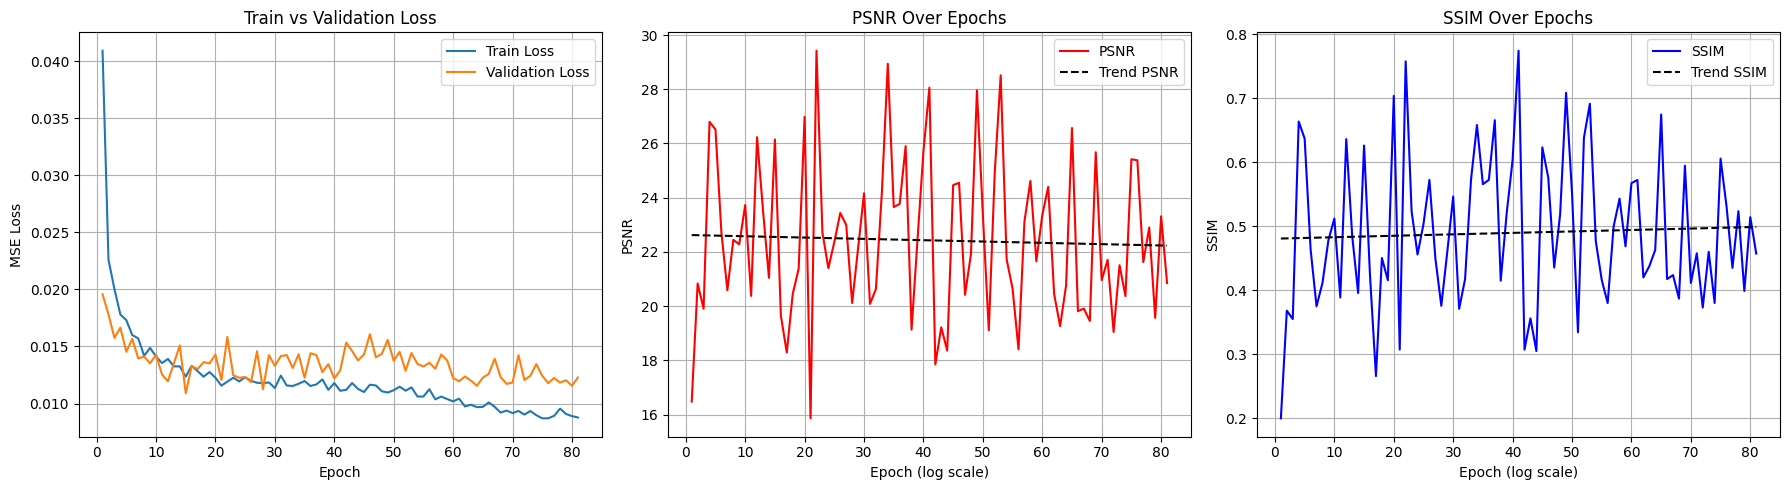

In [4]:
import os
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "history.txt")

# Check if file exists
if not os.path.exists(history_file):
    raise FileNotFoundError(f"Loss history file not found at: {history_file}")

# Read and parse loss history
epochs, train_losses, val_losses, psnr_avgs, ssim_avgs = [], [], [], [], []

with open(history_file, "r") as f:
    lines = f.readlines()[1:]  # Skip header
    for line in lines:
        epoch, train_loss, val_loss, psnr, ssim = line.strip().split("\t")
        epochs.append(int(epoch))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        psnr_avgs.append(float(psnr))
        ssim_avgs.append(float(ssim))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Loss
axs[0].plot(epochs, train_losses, label="Train Loss")
axs[0].plot(epochs, val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("MSE Loss")
axs[0].set_title("Train vs Validation Loss")
axs[0].legend()
axs[0].grid(True)

import numpy as np

# Calcolo retta di regressione per PSNR
coeffs_psnr = np.polyfit(epochs, psnr_avgs, 1)
trend_psnr = np.poly1d(coeffs_psnr)

# Calcolo retta di regressione per SSIM
coeffs_ssim = np.polyfit(epochs, ssim_avgs, 1)
trend_ssim = np.poly1d(coeffs_ssim)

# Plot PSNR
axs[1].plot(epochs, psnr_avgs, label="PSNR", color='red')
axs[1].plot(epochs, trend_psnr(epochs), '--', label="Trend PSNR", color='black')
axs[1].set_xlabel("Epoch (log scale)")
axs[1].set_ylabel("PSNR")
axs[1].set_title("PSNR Over Epochs")
axs[1].legend()
axs[1].grid(True)

# Plot SSIM
axs[2].plot(epochs, ssim_avgs, label="SSIM", color='blue')
axs[2].plot(epochs, trend_ssim(epochs), '--', label="Trend SSIM", color='black')
axs[2].set_xlabel("Epoch (log scale)")
axs[2].set_ylabel("SSIM")
axs[2].set_title("SSIM Over Epochs")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [5]:
from utils import *
from IPPy import metrics

ON_COLAB = False  # Set to True if running on Google Colab

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch81.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

SAMPLE_FROM_PURE_NOISE = True
SAMPLE_FROM_VALIDATION = True

if SAMPLE_FROM_PURE_NOISE:
    # Sample images from pure noise
    sample_images_from_pure_noise(
        output_dir=model_save_dir,
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
        epoch=start_epoch,
        max_examples=10,
    )

if SAMPLE_FROM_VALIDATION:
    # Sample images
    original_images, reconstructed_images = sample_images_from_validation(
        model=model,
        noise_scheduler=noise_scheduler,
        test_loader=test_loader,
        output_dir=RESULT_DIR,
        num_timesteps=NUM_TRAIN_TIMESTEPS,
        device=DEVICE,
        max_examples=100,
        epoch=start_epoch,
        save_images=False,
    )

    # Compute PSNR and SSIM between original and reconstructed images
    psnr_values = []
    ssim_values = []
    from torchvision import transforms

    to_tensor = transforms.ToTensor()

    for orig, rec in zip(original_images, reconstructed_images):
        orig_t = to_tensor(orig).to(DEVICE)
        rec_t = to_tensor(rec).to(DEVICE)

        orig_t = orig_t.unsqueeze(0)
        rec_t = rec_t.unsqueeze(0)

        psnr_value = metrics.PSNR(orig_t.cpu(), rec_t.cpu())
        ssim_value = metrics.SSIM(orig_t.cpu(), rec_t.cpu())
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    # Print average PSNR and SSIM
    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)

    print(f"\n")
    print(f"Average PSNR: {avg_psnr:.4f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(
/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:27: UserWarning: ASTRA toolbox not found. CTProjector will not work.
  warnings.warn("ASTRA toolbox not found. CTProjector will not work.")


Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch81.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch81.pth' (epoch 81)
Model ddim_unet_epoch81.pth loaded successfully to cuda, starting from epoch 81.


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 50.25step/s]


Sample saved to checkpoints/epoch_81_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.13step/s]


Sample saved to checkpoints/epoch_81_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.02step/s]


Sample saved to checkpoints/epoch_81_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.20step/s]


Sample saved to checkpoints/epoch_81_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.20step/s]


Sample saved to checkpoints/epoch_81_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.16step/s]


Sample saved to checkpoints/epoch_81_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.14step/s]


Sample saved to checkpoints/epoch_81_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.14step/s]


Sample saved to checkpoints/epoch_81_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 51.06step/s]


Sample saved to checkpoints/epoch_81_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:19<00:00, 50.88step/s]


Sample saved to checkpoints/epoch_81_9.png


Reconstructions:   4%|▎         | 6/164 [00:02<01:08,  2.32it/s]



Average PSNR: 22.5223 dB
Average SSIM: 0.5272


# Evaluation

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch81.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch81.pth' (epoch 81)
Model ddim_unet_epoch81.pth loaded successfully to cuda, starting from epoch 81.


Processing images: 100%|██████████| 5/5 [01:39<00:00, 19.95s/image]


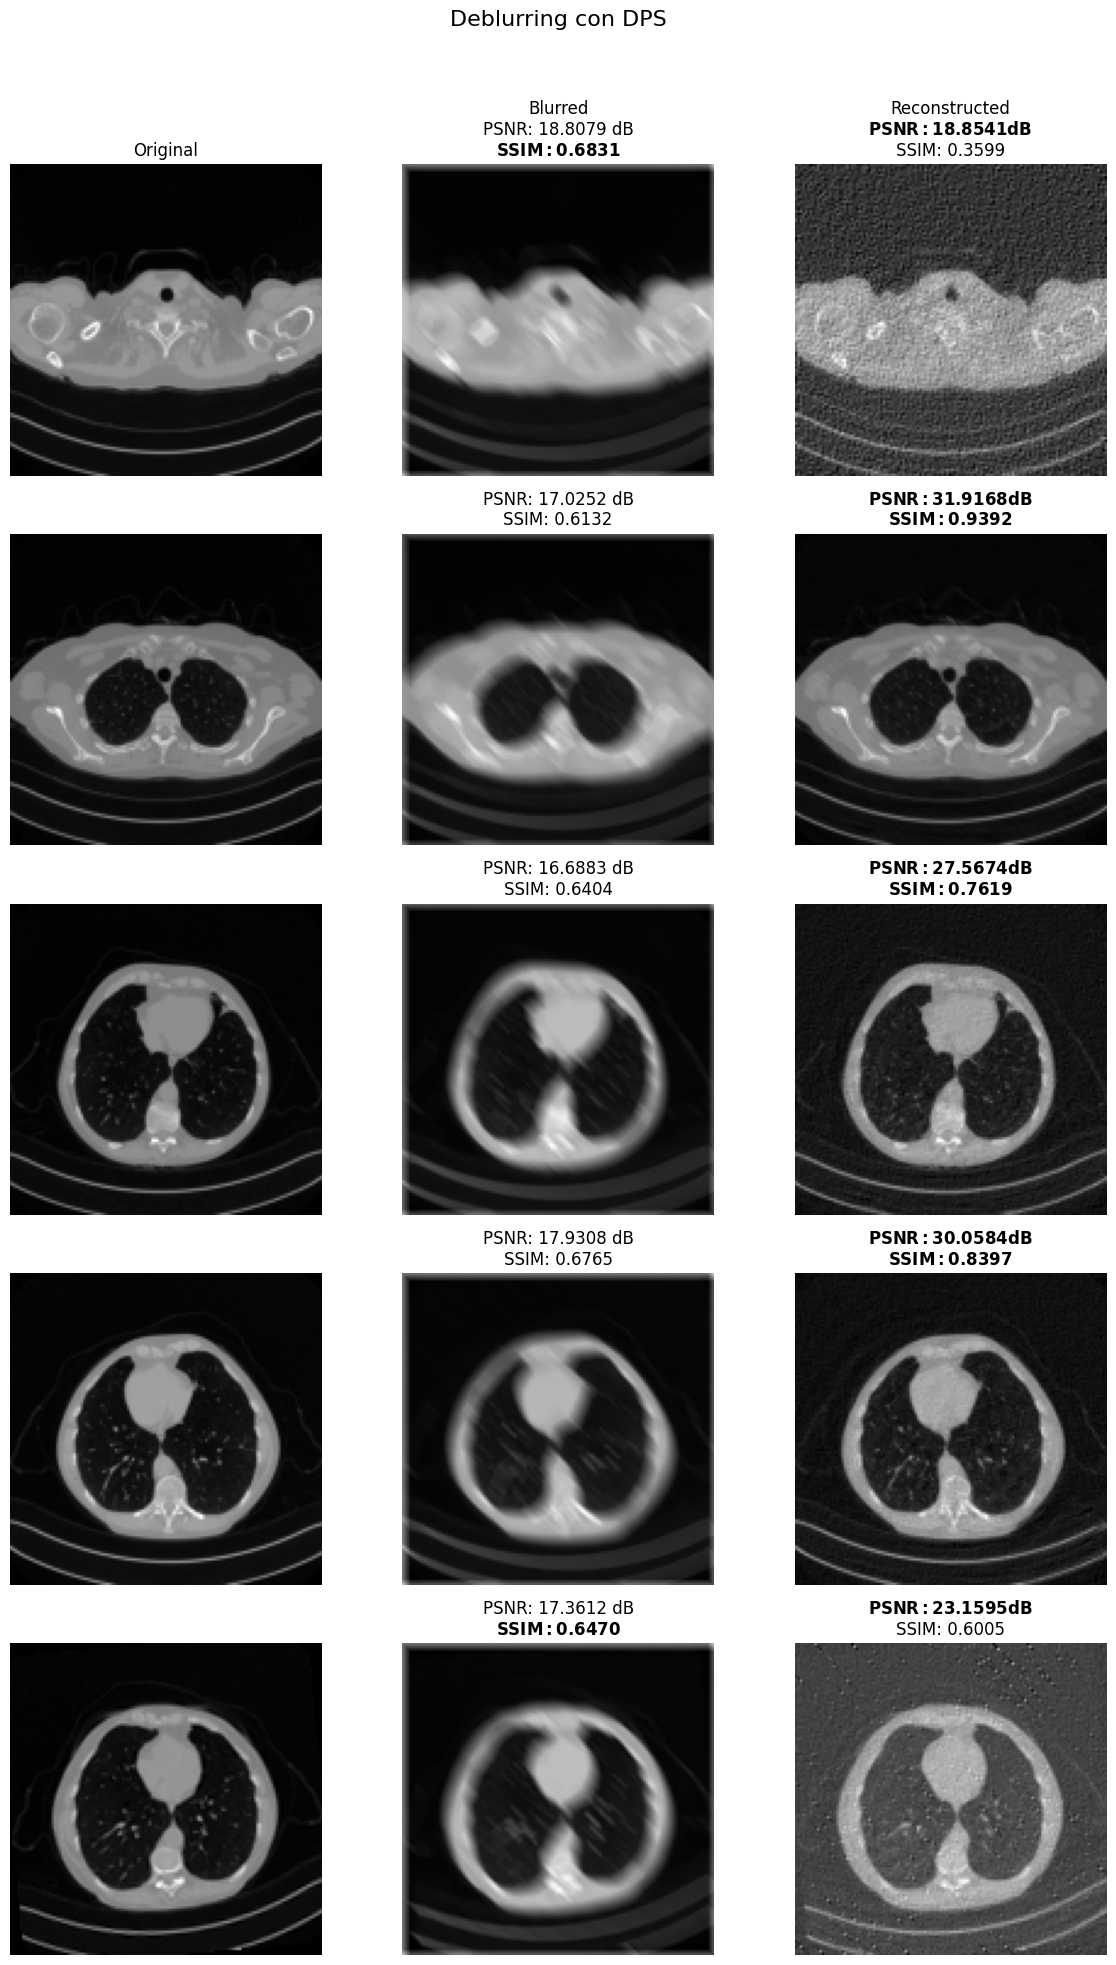

In [6]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch81.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


dps_deblur_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    ddim_scheduler=ddim_scheduler,
    noise_scheduler=noise_scheduler,
    device=DEVICE,
)

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch81.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch81.pth' (epoch 81)
Model ddim_unet_epoch81.pth loaded successfully to cuda, starting from epoch 81.


Processing images: 100%|██████████| 5/5 [01:45<00:00, 21.11s/image]


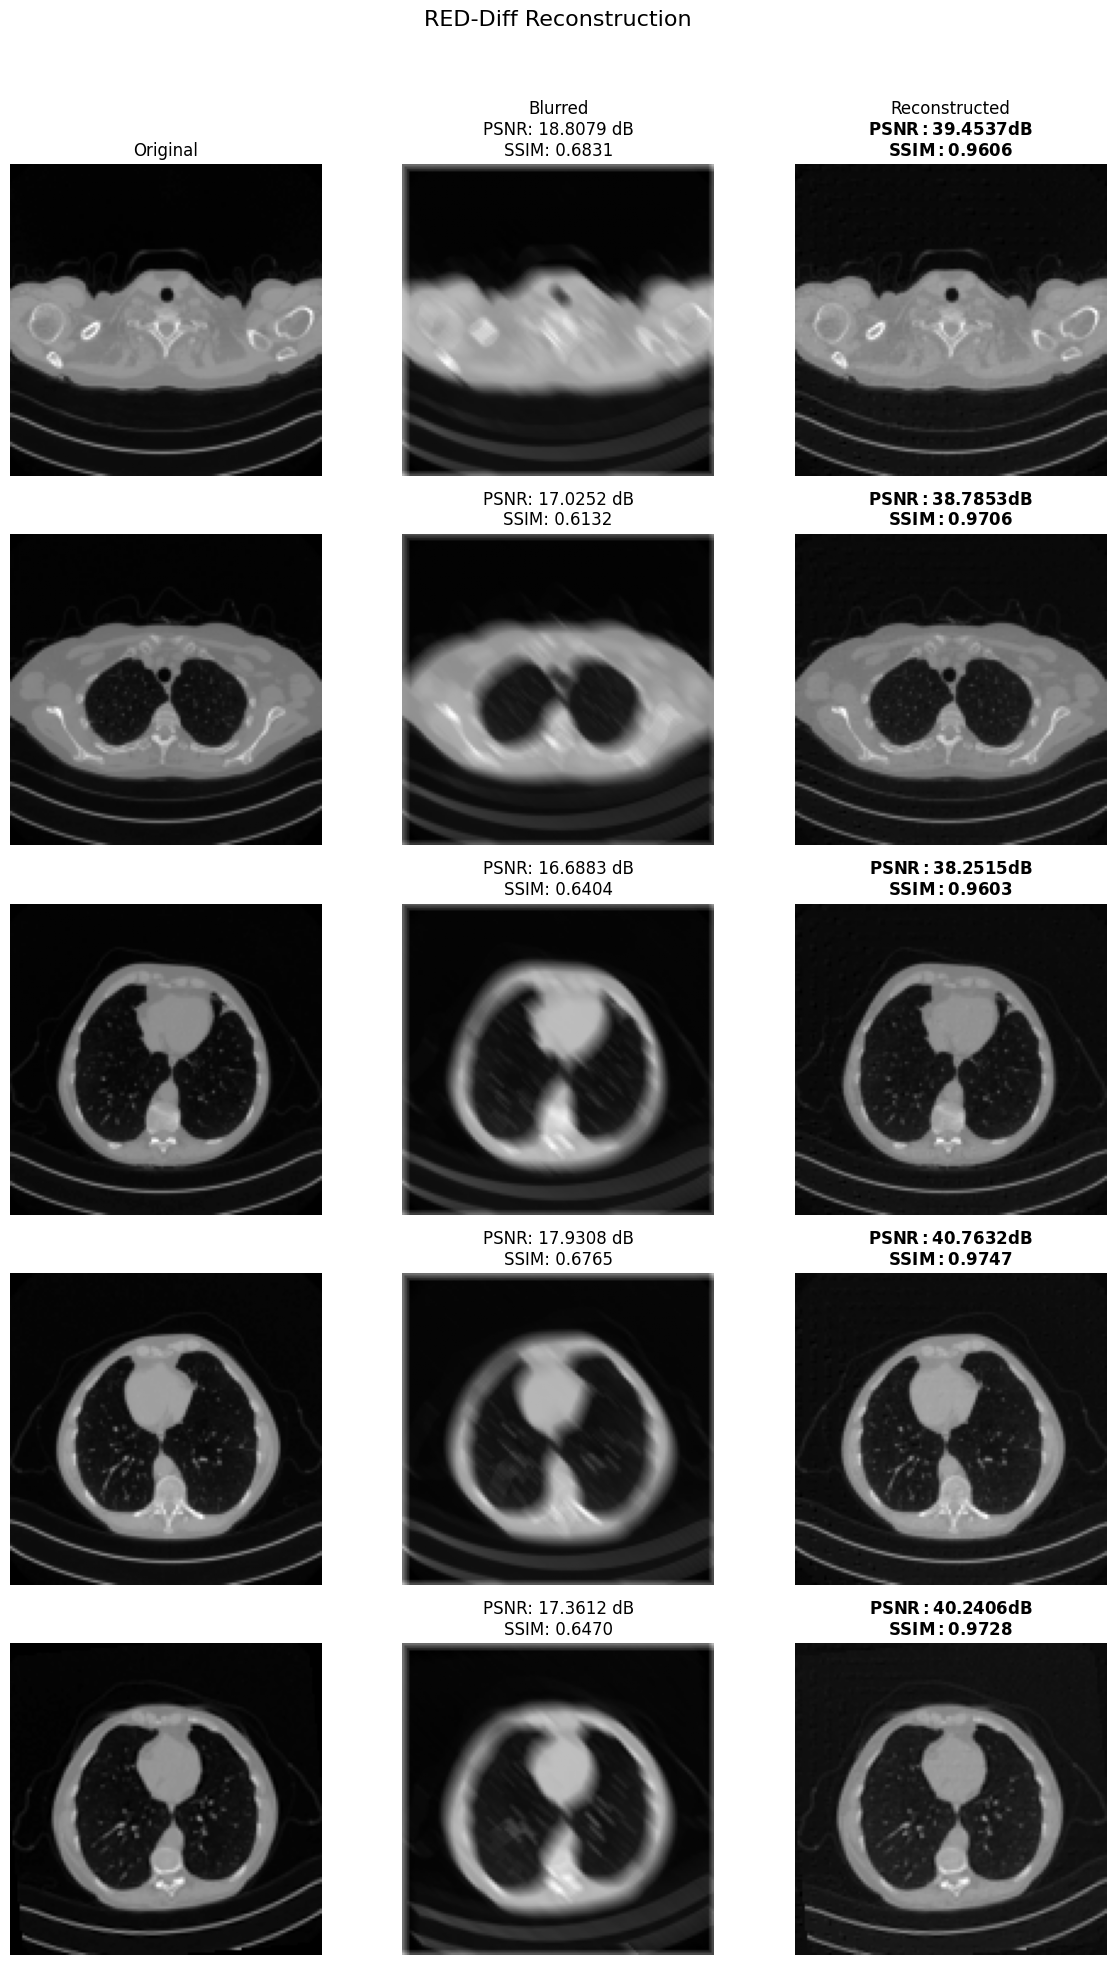

In [7]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch81.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


red_diff_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    noise_scheduler=noise_scheduler,
    ddim_scheduler=ddim_scheduler,
    device=DEVICE,
)

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch81.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch81.pth' (epoch 81)
Model ddim_unet_epoch81.pth loaded successfully to cuda, starting from epoch 81.

=== Kernel size: 5 ===


 Image  1: PSNR (RED-Diff) = 42.56 dB, PSNR (DPS) = 32.86 dB | SSIM (RED-Diff) = 0.9830, SSIM (DPS) = 0.9002


 Image  2: PSNR (RED-Diff) = 42.26 dB, PSNR (DPS) = 33.68 dB | SSIM (RED-Diff) = 0.9812, SSIM (DPS) = 0.9209


 Image  3: PSNR (RED-Diff) = 41.37 dB, PSNR (DPS) = 36.64 dB | SSIM (RED-Diff) = 0.9782, SSIM (DPS) = 0.9566


 Image  4: PSNR (RED-Diff) = 42.49 dB, PSNR (DPS) = 34.10 dB | SSIM (RED-Diff) = 0.9839, SSIM (DPS) = 0.9225


 Image  5: PSNR (RED-Diff) = 39.39 dB, PSNR (DPS) = 29.67 dB | SSIM (RED-Diff) = 0.9924, SSIM (DPS) = 0.9454
--> Mean over 5 images: PSNR (RED-Diff) = 41.61 dB, PSNR (DPS) = 33.39 dB | SSIM (RED-Diff) = 0.9837, SSIM (DPS) = 0.9291

=== Kernel size: 7 ===


 Image  1: PSNR (RED-Diff) = 39.94 dB, PSNR (DPS) = 30.24 dB | SSIM (RED-Diff) = 0.9741, SSIM (DPS) = 0.8675


 Image  2: PSNR (RED-Diff) = 39.37 dB, PSNR (DPS) = 28.34 dB | SSIM (RED-Diff) = 0.9706, SSIM (DPS) = 0.7770


 Image  3: PSNR (RED-Diff) = 39.39 dB, PSNR (DPS) = 31.83 dB | SSIM (RED-Diff) = 0.9695, SSIM (DPS) = 0.9081


 Image  4: PSNR (RED-Diff) = 40.38 dB, PSNR (DPS) = 33.51 dB | SSIM (RED-Diff) = 0.9755, SSIM (DPS) = 0.9342


 Image  5: PSNR (RED-Diff) = 37.10 dB, PSNR (DPS) = 22.48 dB | SSIM (RED-Diff) = 0.9878, SSIM (DPS) = 0.7412
--> Mean over 5 images: PSNR (RED-Diff) = 39.24 dB, PSNR (DPS) = 29.28 dB | SSIM (RED-Diff) = 0.9755, SSIM (DPS) = 0.8456

=== Kernel size: 9 ===


 Image  1: PSNR (RED-Diff) = 39.94 dB, PSNR (DPS) = 25.10 dB | SSIM (RED-Diff) = 0.9741, SSIM (DPS) = 0.6810


 Image  2: PSNR (RED-Diff) = 39.37 dB, PSNR (DPS) = 23.54 dB | SSIM (RED-Diff) = 0.9706, SSIM (DPS) = 0.6201


 Image  3: PSNR (RED-Diff) = 39.39 dB, PSNR (DPS) = 28.48 dB | SSIM (RED-Diff) = 0.9695, SSIM (DPS) = 0.7930


 Image  4: PSNR (RED-Diff) = 40.38 dB, PSNR (DPS) = 33.58 dB | SSIM (RED-Diff) = 0.9755, SSIM (DPS) = 0.9395


 Image  5: PSNR (RED-Diff) = 37.10 dB, PSNR (DPS) = 24.48 dB | SSIM (RED-Diff) = 0.9878, SSIM (DPS) = 0.8323
--> Mean over 5 images: PSNR (RED-Diff) = 39.24 dB, PSNR (DPS) = 27.03 dB | SSIM (RED-Diff) = 0.9755, SSIM (DPS) = 0.7732

=== Kernel size: 11 ===


 Image  1: PSNR (RED-Diff) = 38.16 dB, PSNR (DPS) = 18.78 dB | SSIM (RED-Diff) = 0.9645, SSIM (DPS) = 0.4071


 Image  2: PSNR (RED-Diff) = 37.68 dB, PSNR (DPS) = 28.96 dB | SSIM (RED-Diff) = 0.9644, SSIM (DPS) = 0.8770


 Image  3: PSNR (RED-Diff) = 38.32 dB, PSNR (DPS) = 27.99 dB | SSIM (RED-Diff) = 0.9654, SSIM (DPS) = 0.8697


 Image  4: PSNR (RED-Diff) = 37.81 dB, PSNR (DPS) = 29.26 dB | SSIM (RED-Diff) = 0.9622, SSIM (DPS) = 0.8831


 Image  5: PSNR (RED-Diff) = 35.63 dB, PSNR (DPS) = 22.32 dB | SSIM (RED-Diff) = 0.9830, SSIM (DPS) = 0.7715
--> Mean over 5 images: PSNR (RED-Diff) = 37.52 dB, PSNR (DPS) = 25.46 dB | SSIM (RED-Diff) = 0.9679, SSIM (DPS) = 0.7617

=== Kernel size: 13 ===


 Image  1: PSNR (RED-Diff) = 35.13 dB, PSNR (DPS) = 19.40 dB | SSIM (RED-Diff) = 0.9420, SSIM (DPS) = 0.4899


 Image  2: PSNR (RED-Diff) = 35.53 dB, PSNR (DPS) = 17.17 dB | SSIM (RED-Diff) = 0.9506, SSIM (DPS) = 0.3601


 Image  3: PSNR (RED-Diff) = 35.28 dB, PSNR (DPS) = 24.07 dB | SSIM (RED-Diff) = 0.9441, SSIM (DPS) = 0.6497


 Image  4: PSNR (RED-Diff) = 35.59 dB, PSNR (DPS) = 10.06 dB | SSIM (RED-Diff) = 0.9510, SSIM (DPS) = 0.1756


 Image  5: PSNR (RED-Diff) = 33.45 dB, PSNR (DPS) = 21.24 dB | SSIM (RED-Diff) = 0.9749, SSIM (DPS) = 0.7346
--> Mean over 5 images: PSNR (RED-Diff) = 35.00 dB, PSNR (DPS) = 18.39 dB | SSIM (RED-Diff) = 0.9525, SSIM (DPS) = 0.4820

=== Kernel size: 15 ===


 Image  1: PSNR (RED-Diff) = 35.13 dB, PSNR (DPS) = 19.39 dB | SSIM (RED-Diff) = 0.9420, SSIM (DPS) = 0.4875


 Image  2: PSNR (RED-Diff) = 35.53 dB, PSNR (DPS) = 23.88 dB | SSIM (RED-Diff) = 0.9506, SSIM (DPS) = 0.6587


 Image  3: PSNR (RED-Diff) = 35.28 dB, PSNR (DPS) = 18.84 dB | SSIM (RED-Diff) = 0.9441, SSIM (DPS) = 0.4123


 Image  4: PSNR (RED-Diff) = 35.59 dB, PSNR (DPS) = 24.47 dB | SSIM (RED-Diff) = 0.9510, SSIM (DPS) = 0.8205


 Image  5: PSNR (RED-Diff) = 33.45 dB, PSNR (DPS) = 24.43 dB | SSIM (RED-Diff) = 0.9749, SSIM (DPS) = 0.8820
--> Mean over 5 images: PSNR (RED-Diff) = 35.00 dB, PSNR (DPS) = 22.20 dB | SSIM (RED-Diff) = 0.9525, SSIM (DPS) = 0.6522

=== Final aggregated results ===
Kernel sizes:           [5, 7, 9, 11, 13, 15]
Mean PSNR (RED-Diff):   ['41.61', '39.24', '39.24', '37.52', '35.00', '35.00']
Mean PSNR (DPS):        ['33.39', '29.28', '27.03', '25.46', '18.39', '22.20']
Mean SSIM (RED-Diff):   ['0.9837', '0.9755', '0.9755', '0.9679', '0.9525', '0.9525']
Mean SSIM (DPS):        ['0.9291', '0.8456', '0.7732', '0.7617', '0.4820', '0.6522']


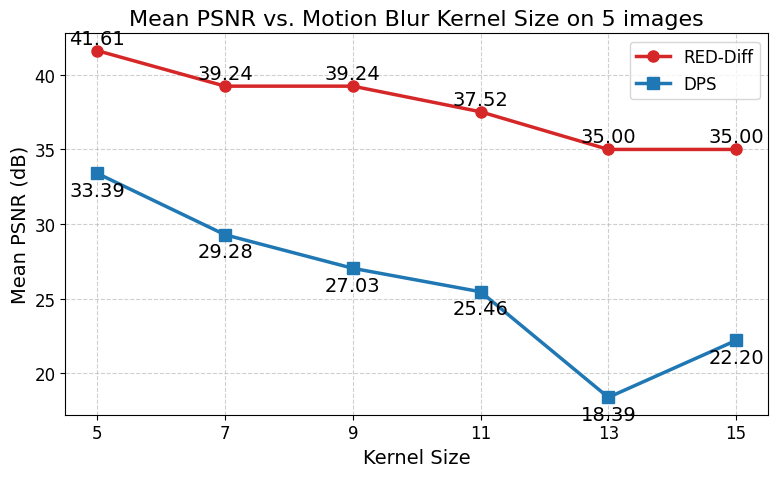

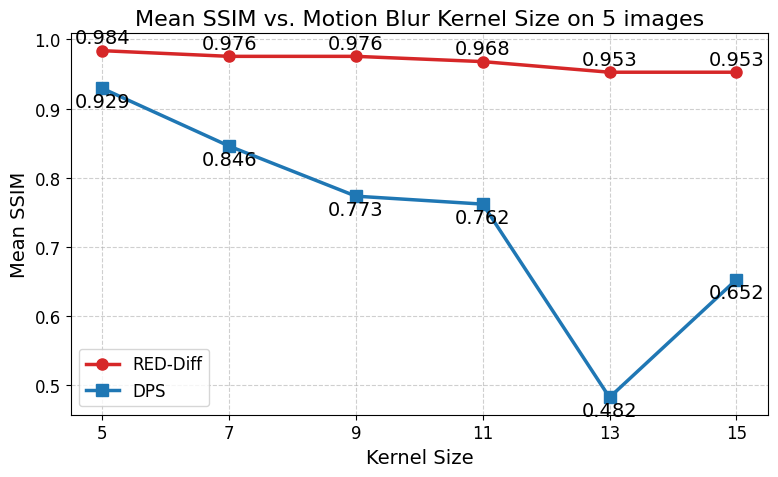

In [8]:
import torch
import os
import numpy as np
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
from tqdm import tqdm

random.seed(42)

# Setup
ON_COLAB = False
data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)
RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & schedulers
model, optimizer = get_unet_model(device=DEVICE)
load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name="ddim_unet_epoch81.pth",
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)
noise_scheduler, ddim_scheduler = get_schedulers()

# Dataloader
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=1,  # una immagine alla volta
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# Parametri
kernel_sizes = [5, 7, 9, 11, 13, 15]  # dimensioni dei kernel da testare
num_images = 5  # numero di immagini da testare per ogni kernel size

psnr_red_all = []
psnr_dps_all = []
ssim_red_all = []
ssim_dps_all = []

for kernel_size in kernel_sizes:
    print(f"\n=== Kernel size: {kernel_size} ===")
    motion_angle = 45
    K = operators.Blurring(
        img_shape=(IMAGE_SIZE, IMAGE_SIZE),
        kernel_size=kernel_size,
        kernel_type="motion",
        motion_angle=motion_angle,
    )

    psnr_red, psnr_dps = [], []
    ssim_red, ssim_dps = [], []

    for i, (x_gt, _) in enumerate(test_loader):
        if i >= num_images:
            break

        x_gt = x_gt.to(DEVICE)
        y = K(x_gt).to(DEVICE)

        # RED-Diff
        x_red = red_diff(
            model=model,
            ddim_scheduler=ddim_scheduler,
            y=y,
            K=K,
            noise_scheduler=noise_scheduler,
            device=DEVICE,
        )
        psnr_red_val = metrics.PSNR(x_gt.cpu(), x_red.cpu())
        ssim_red_val = metrics.SSIM(x_gt.cpu(), x_red.cpu())
        psnr_red.append(psnr_red_val)
        ssim_red.append(ssim_red_val)

        # DPS
        x_dps = dps_deblur(
            model=model,
            ddim_scheduler=ddim_scheduler,
            y=y,
            K=K,
            noise_scheduler=noise_scheduler,
            device=DEVICE,
        )
        psnr_dps_val = metrics.PSNR(x_gt.cpu(), x_dps.cpu())
        ssim_dps_val = metrics.SSIM(x_gt.cpu(), x_dps.cpu())
        psnr_dps.append(psnr_dps_val)
        ssim_dps.append(ssim_dps_val)

        # Print per-image results (optional)
        print(
            f" Image {i + 1:>2}: "
            f"PSNR (RED-Diff) = {psnr_red_val:.2f} dB, "
            f"PSNR (DPS) = {psnr_dps_val:.2f} dB | "
            f"SSIM (RED-Diff) = {ssim_red_val:.4f}, "
            f"SSIM (DPS) = {ssim_dps_val:.4f}"
        )

    mean_psnr_red = np.mean(psnr_red)
    mean_psnr_dps = np.mean(psnr_dps)
    mean_ssim_red = np.mean(ssim_red)
    mean_ssim_dps = np.mean(ssim_dps)

    psnr_red_all.append(mean_psnr_red)
    psnr_dps_all.append(mean_psnr_dps)
    ssim_red_all.append(mean_ssim_red)
    ssim_dps_all.append(mean_ssim_dps)

    # Print per-kernel-size summary
    print(
        f"--> Mean over {num_images} images: "
        f"PSNR (RED-Diff) = {mean_psnr_red:.2f} dB, "
        f"PSNR (DPS) = {mean_psnr_dps:.2f} dB | "
        f"SSIM (RED-Diff) = {mean_ssim_red:.4f}, "
        f"SSIM (DPS) = {mean_ssim_dps:.4f}"
    )

# After looping through all kernel sizes, you can print the full lists:
print("\n=== Final aggregated results ===")
print("Kernel sizes:          ", kernel_sizes)
print("Mean PSNR (RED-Diff):  ", [f"{v:.2f}" for v in psnr_red_all])
print("Mean PSNR (DPS):       ", [f"{v:.2f}" for v in psnr_dps_all])
print("Mean SSIM (RED-Diff):  ", [f"{v:.4f}" for v in ssim_red_all])
print("Mean SSIM (DPS):       ", [f"{v:.4f}" for v in ssim_dps_all])

# --- Common styling parameters ---
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
    }
)

# Choose a colorblind-friendly palette
colors = plt.get_cmap("tab10")

# --- PSNR Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kernel_sizes, psnr_red_all, label="RED-Diff", marker="o", color=colors(3))
ax.plot(kernel_sizes, psnr_dps_all, label="DPS", marker="s", color=colors(0))
ax.set_title(f"Mean PSNR vs. Motion Blur Kernel Size on {num_images} images")
ax.set_xlabel("Kernel Size")
ax.set_ylabel("Mean PSNR (dB)")
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(kernel_sizes)

# Annotate each point
for x, y in zip(kernel_sizes, psnr_red_all):
    ax.text(x, y + 0.2, f"{y:.2f}", ha="center", va="bottom")
for x, y in zip(kernel_sizes, psnr_dps_all):
    ax.text(x, y - 0.5, f"{y:.2f}", ha="center", va="top")

ax.legend(loc="best")
fig.tight_layout()
# fig.savefig(os.path.join(RESULT_DIR, "psnr_comparison.png"), dpi=300)
plt.show()

# --- SSIM Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kernel_sizes, ssim_red_all, label="RED-Diff", marker="o", color=colors(3))
ax.plot(kernel_sizes, ssim_dps_all, label="DPS", marker="s", color=colors(0))
ax.set_title(f"Mean SSIM vs. Motion Blur Kernel Size on {num_images} images")
ax.set_xlabel("Kernel Size")
ax.set_ylabel("Mean SSIM")
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(kernel_sizes)

# Annotate each point
for x, y in zip(kernel_sizes, ssim_red_all):
    ax.text(x, y + 0.005, f"{y:.3f}", ha="center", va="bottom")
for x, y in zip(kernel_sizes, ssim_dps_all):
    ax.text(x, y - 0.005, f"{y:.3f}", ha="center", va="top")

ax.legend(loc="best")
fig.tight_layout()
# fig.savefig(os.path.join(RESULT_DIR, "ssim_comparison.png"), dpi=300)
plt.show()